In [59]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the training data into feature matrix, class labels, and event ids:

In [60]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [61]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

In [77]:
from implementations import *

# Exploratory analysis

In [5]:
#tX0 = np.where(tX==-999, np.nan,tX)

#for f in [2, 6, 10, 15, 20, 27]:
 #   plot_feature(ids, tX0, y, f)

# Data pre-processing 

# Feature processing

Then with this data, we separate the data points based on the categorical data: jet. We keep three matrices with `jet = 0`, `jet = 1` and `jet > 2`. We will futher train separately our models on each of these sub-matrices and have separated, learning rates, penalities or polynomial degrees for each. 

We still keep the whole data matrix to do the same treatments and generate whole weight matrices as a comparison. 

In [6]:
indices = np.random.choice(tX.shape[0], 1500, replace=False)

In [7]:
y = y[indices,]
tX = tX[indices,:]

In [63]:
idx0, y_jet0, tX_jet0, idx1, y_jet1, tX_jet1, idx2, y_jet2, tX_jet2 = separate_jet(y, tX)

For each dataset, we clean them by setting all missing values `-999` to `NaN`, then when for a feature the ratio of missing values reaches a threshold, we remove the whole feature from the dataset. The remaining missing data are replaced by the median value in the column (we also tried to replace the missing data by the mean value of the feature or a gaussian distribution. Then we standarize the data. 

In [64]:
missingness_cutoff = 0.95

In [65]:
tX, rmX = missingness_filter(tX, missingness_cutoff)

In [66]:
tX, mtX = impute_median_train(tX)

In [67]:
tX_jet0, rmX_jet0 = missingness_filter(tX_jet0, missingness_cutoff)
tX_jet1, rmX_jet1 = missingness_filter(tX_jet1, missingness_cutoff)
tX_jet2, rmX_jet2 = missingness_filter(tX_jet2, missingness_cutoff)
tX_jet0, median_jet0 = impute_median_train(tX_jet0)
tX_jet1, median_jet1 = impute_median_train(tX_jet1)
tX_jet2, median_jet2 = impute_median_train(tX_jet2)

In [68]:
print("tX shape={tXs}\ntX_jet0 shape={tX0s}\ntX_jet1 shape={tX1s}\ntX_jet2+ shape={tX2s}".format(
    tXs=tX.shape, tX0s=tX_jet0.shape, tX1s=tX_jet1.shape, tX2s=tX_jet2.shape))

print("\nremoved columns for :\ntX={rmX}\ntX_jet0={rmX0}\ntX_jet1={rmX1}\ntX_jet2+={rmX2}".format(
    rmX=rmX, rmX0=rmX_jet0, rmX1=rmX_jet1, rmX2=rmX_jet2))

tX shape=(250000, 30)
tX_jet0 shape=(99913, 18)
tX_jet1 shape=(77544, 22)
tX_jet2+ shape=(72543, 29)

removed columns for :
tX=[]
tX_jet0=[ 4  5  6 12 22 23 24 25 26 27 28]
tX_jet1=[ 4  5  6 12 25 26 27]
tX_jet2+=[]


## Least squares

### Full dataset

In [14]:
tX1,_,_ = standardize_train(tX.copy())

In [15]:
(w_ls, loss_ls) = least_squares(y, tX1)

print("w* ={w}\n\nmse={loss}".format(w=w_ls, loss=loss_ls))

w* =[-5.89857978e-03 -2.82271952e-01 -2.36375457e-01  2.68792493e-02
  2.55544044e-01  1.46791716e-02 -7.69783046e+03 -1.15000073e-01
  8.03810859e-02  1.26041521e+03  8.68825976e-03 -1.72456123e-02
  1.49883637e+03  1.72440839e-02  5.33418632e-03  6.41253645e-02
 -3.67233446e-02 -6.31721362e-02  1.87502536e-01  1.57264328e-01
 -3.28648197e-02 -3.10274739e-02  6.52616628e+03]

mse=0.40202483838040326


### Jet sub-datasets

In [16]:
for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    tx1, _, _ = standardize_train(txi.copy())
    (w_ls, loss_ls) = least_squares(yi, tx1)
    print("w_jet{jet}* = {w}\nmse = {loss}\n\n".format(
    jet=index_jet, w=w_ls, loss=loss_ls))

w_jet0* = [ 1.55974137e-02 -2.75936805e-01 -4.42774856e-01 -6.02082509e+11
  3.99131464e-01  6.02082509e+11  1.42522452e+00 -1.35138708e-01
 -4.02877430e-03 -6.71313136e-01  5.59663347e-03 -1.53083132e-02
 -7.24841070e-01  3.64668567e-02 -2.27656411e-02  1.18905114e-01
 -2.68313433e-02  5.63852872e-03]
mse = 0.3777197355776623


w_jet1* = [-6.42660253e-02 -3.18443157e-01 -2.34182484e-01 -3.46345302e-02
  3.15747316e-01  9.21979738e-02 -2.92098674e+03 -1.88020185e-01
  2.69099486e-02  9.59459983e+02  4.17379891e-03 -2.61352213e-02
  1.06872964e+03  6.97425064e-03  9.97791657e-03  1.67533160e-01
 -2.00378545e-02 -6.04594626e-02 -7.96817579e+03 -3.29343082e-02
 -5.92394684e-02  1.01095681e+04]
mse = 0.3875902021292971


w_jet2* = [ 6.13475137e-02 -1.58593863e-01 -1.34252290e-01  2.22300184e-01
  9.14893853e-02  2.05680573e-01  8.94968725e-03  1.22987059e-01
 -1.54068917e-02 -2.11900777e+04  5.24711700e-02  7.37196410e-02
  1.26733491e-01  3.78621933e+03 -1.59112534e-02 -2.34447300e-02
  4

## Least squares with Gradient Descent

### Full dataset

In [17]:
#define parameters
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_gd = np.empty(len(gammas))
ws_gd = np.empty((len(gammas), len(initial_w)))

tX1,_,_ = standardize_train(tX)

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_GD(y, tX1, initial_w, max_iters, gamma)
    losses_gd[idx] = loss
    ws_gd[idx, :]=w

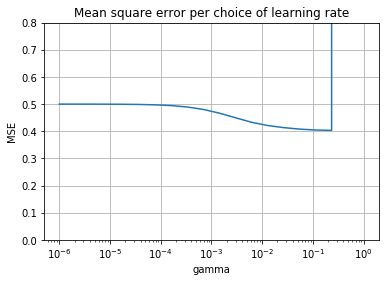

In [18]:
#plot the losses per gamma
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 0.8])
plt.show()

In [19]:
idx = np.nanargmin(losses_gd)

w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w* =[-0.0083608  -0.28486942 -0.21667288  0.03805861  0.2427864   0.00799546
 -0.02888503 -0.10001142  0.08377105  0.25370034  0.00808048 -0.01646442
  0.24109384  0.01800697  0.00265113  0.06511877 -0.03912197 -0.08018892
  0.09933085  0.06584056 -0.03239378 -0.03213008 -0.13840877]

mse=0.4032813932759099

gamma=0.23357214690901212


### Jet sub-datasets

In [20]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0.copy(), tX_jet1.copy(), tX_jet2.copy()])):
    tx1, _, _ = standardize_train(txi.copy())
    initial_w = np.zeros(tx1.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_GD(yi, tx1, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w_jet0* = [ 3.87165248e-04 -2.59911328e-01 -3.98951018e-01  2.92086621e-02
  3.69574241e-01  2.92086621e-02  1.57412805e-01 -9.41951425e-02
  5.60918530e-03  1.95038293e-01  4.95737475e-03 -1.65377673e-02
  4.40774949e-02  3.71845972e-02 -2.46240095e-02  9.68723482e-02
 -2.59048610e-02  5.25289048e-03]
mse = 0.3779852307928842
gamma = 0.21544346900318823
w_jet1* = [-0.07024781 -0.31722569 -0.2199666  -0.04851935  0.30898023  0.09251857
  0.15227775 -0.13584251  0.03547443  0.21623943  0.00446433 -0.02210851
  0.23954513  0.00762429  0.00695866  0.175926   -0.01853943 -0.05983733
 -0.00865101 -0.03205761 -0.06233593 -0.00865072]
mse = 0.3883053039235435
gamma = 0.21544346900318823
w_jet2* = [ 0.06680208 -0.17212933 -0.1189905   0.15825694  0.1054962   0.20103486
  0.02384651  0.09546022 -0.0177606  -0.02381248  0.06222585  0.07930311
  0.13104832  0.22336012 -0.01900752 -0.02294682  0.05710275 -0.00829254
  0.05687597 -0.09037387 -0.04756451 -0.10738956  0.01968812 -0.03235751
  0.01857

## Least squares with Stochastic Gradient Descent

### Full dataset

In [21]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_sgd = np.empty(len(gammas))
ws_sgd = np.empty((len(gammas), len(initial_w)))

tX1, _, _ = standardize_train(tX.copy())

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_SGD(y, tX1, initial_w, max_iters, gamma)
    losses_sgd[idx] = loss
    ws_sgd[idx,:] = w

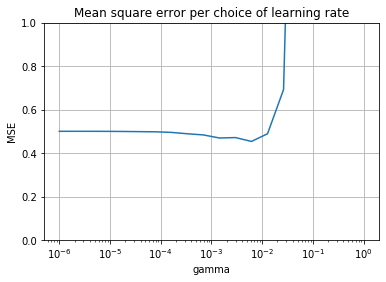

In [22]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [23]:
idx = np.nanargmin(losses_sgd)

w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w*={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=losses_sgd[idx], gamma=gamma_sgd ))

w*=[ 0.07812133 -0.10074855  0.07674723  0.05705817  0.04514771 -0.0180589
  0.00762491 -0.04088091  0.12097923  0.14165306  0.02472997 -0.0166117
  0.02323159 -0.01746408  0.01064638 -0.03465458  0.01693141  0.00937517
 -0.02135959  0.00097664  0.02742991 -0.08976399 -0.02369194]

mse=0.45330753627056114

gamma=0.00615848211066026


### Jet sub-datasets

In [24]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    tx1, _, _ = standardize_train(txi.copy())
    initial_w = np.zeros(tx1.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_SGD(yi, tx1, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w_jet0* = [-0.01508906 -0.06120648 -0.0136519   0.01791324  0.03674875  0.01791324
  0.01555289 -0.07068042  0.04122954  0.060347   -0.0248859  -0.03047896
 -0.03814041 -0.04093366  0.02217503 -0.01908116  0.01639233  0.01830199]
mse = 0.43774560692830833
gamma = 0.002154434690031882
w_jet1* = [ 0.07923503 -0.13227666  0.05892574  0.01829675  0.11286285  0.09526671
  0.06298436 -0.10445666  0.02102302  0.15460096  0.00997714 -0.01111108
 -0.00502483  0.01780613 -0.10893009  0.05878713  0.0162312   0.11303821
  0.01917064 -0.0427645  -0.08517293  0.01917065]
mse = 0.4455293142545773
gamma = 0.01
w_jet2* = [-0.04965973 -0.11873979 -0.01774302  0.0082163   0.06300572  0.10121855
 -0.09500553 -0.04450361 -0.10968659 -0.00183218 -0.00114316  0.09289095
  0.08299701  0.02558992 -0.02634489  0.03875908 -0.06209688  0.01468916
  0.07611407 -0.10070459  0.00154432 -0.07373131  0.03495396 -0.06637241
 -0.03101794  0.0660544   0.05506674 -0.01826107  0.00995944]
mse = 0.41765846347904306
gamma = 

## Ridge regression

For ridge regression, we have two parameters to optimize, the lambda (penality) and degree (complexity). To do so, we use a cross validation that optimizes both at the same time. 

Then a biais and variance decomposition is used to visualize if the methods tend to underfit or overfit. 

### Full dataset

#### Cross-validation hyperparameter selection

In [69]:
w_interaction = False

In [26]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-20, -8, 13)
degrees = range(1, 15)

k_indices = build_k_indices(y, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y, tX, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

Finished preparing data for cross-validation 

Completed degree 14/14
 Completed lambda 1/13
Completed degree 14/14
 Completed lambda 2/13
Completed degree 14/14
 Completed lambda 3/13
Completed degree 14/14
 Completed lambda 4/13
Completed degree 14/14
 Completed lambda 5/13
Completed degree 14/14
 Completed lambda 6/13
Completed degree 14/14
 Completed lambda 7/13
Completed degree 14/14
 Completed lambda 8/13
Completed degree 14/14
 Completed lambda 9/13
Completed degree 14/14
 Completed lambda 10/13
Completed degree 14/14
 Completed lambda 11/13
Completed degree 14/14
 Completed lambda 12/13
Completed degree 14/14
 Completed lambda 13/13


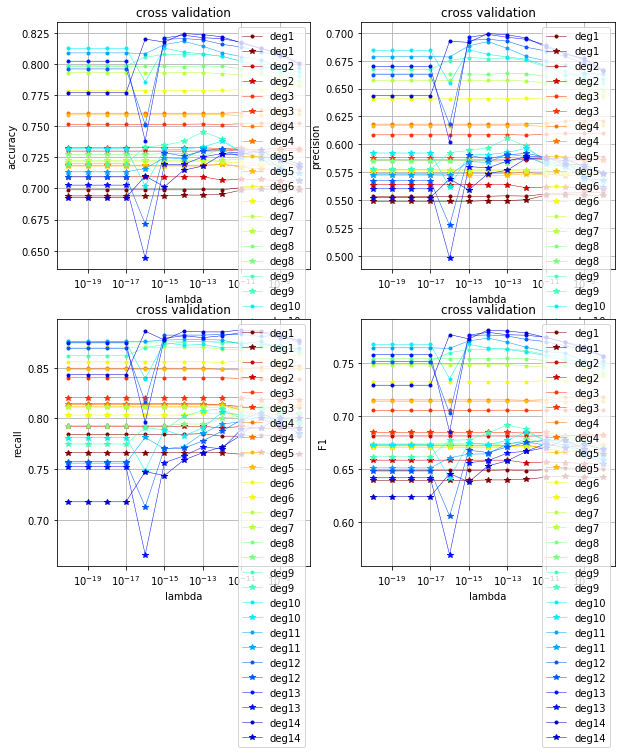

In [27]:
vis_cv_acc(degrees,lambdas,acc_measures)

In [28]:
idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

lambda*=1e-13

degree*=9

rmse train=0.28326229025571575

rmse test=8415372.952917434

acc train=0.8079999999999999

acc test=0.7453333333333333


In [29]:
w_ri, loss_ri, acc_measures_ri, data_meas_ri = build_final_model(y, tX, degree_ri,
                                                      lambda_ri, ml_function = 'ri', interaction = w_interaction)

In [30]:
print(acc_measures_ri)

{'acc': 0.794, 'pre': 0.6599713055954088, 'rec': 0.8646616541353384, 'f1': 0.7485760781122863}


### Jet sub-datasets

#### Cross-validation for hyperparameter selection

In [81]:
seed = 1
k_fold = 4
lambdas = np.logspace(-20, -8, 13)
degrees = range(1, 11)

k_indices = build_k_indices(y_jet0, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet0, tX_jet0, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet0 = lambdas[idx[0]]
degree_ri_jet0 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet0, degree=degree_ri_jet0, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

Finished preparing data for cross-validation 

Completed degree 10/10
 Completed lambda 1/13
Completed degree 10/10
 Completed lambda 2/13
Completed degree 10/10
 Completed lambda 3/13
Completed degree 10/10
 Completed lambda 4/13
Completed degree 10/10
 Completed lambda 5/13
Completed degree 10/10
 Completed lambda 6/13
Completed degree 10/10
 Completed lambda 7/13
Completed degree 10/10
 Completed lambda 8/13
Completed degree 10/10
 Completed lambda 9/13
Completed degree 10/10
 Completed lambda 10/13


KeyboardInterrupt: 

In [32]:
w0_ri, loss0_ri, acc_measures0_ri, data_meas0_ri = build_final_model(y_jet0, tX_jet0, degree_ri_jet0,
                                                      lambda_ri_jet0, ml_function = 'ri', interaction = w_interaction)

print(acc_measures0_ri)

{'acc': 0.7679738562091504, 'pre': 0.550185873605948, 'rec': 0.8757396449704142, 'f1': 0.6757990867579909}


Finished preparing data for cross-validation 

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5
lambda*=0.01

degree*=2

rmse train=0.3439266588360252

rmse test=0.417849172140925

acc train=0.7478070175438597

acc test=0.6885964912280701


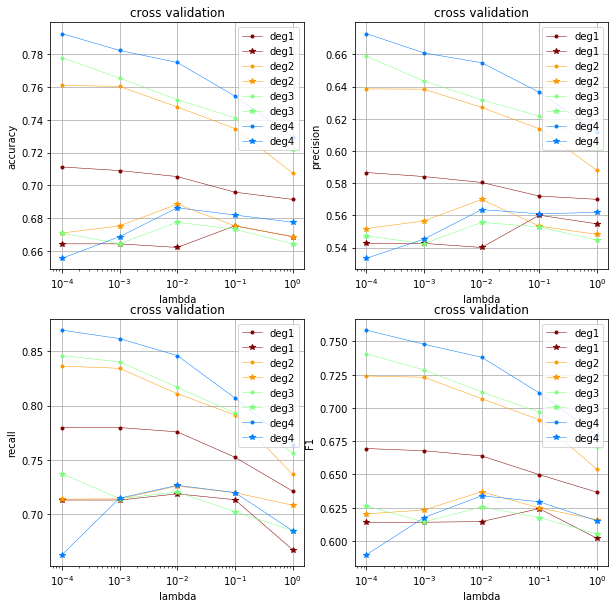

In [33]:
k_indices = build_k_indices(y_jet1, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet1, tX_jet1, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet1 = lambdas[idx[0]]
degree_ri_jet1 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet1, degree=degree_ri_jet1, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)



In [34]:
w1_ri, loss1_ri, acc_measures1_ri, data_meas1_ri = build_final_model(y_jet1, tX_jet1, degree_ri_jet1,
                                                      lambda_ri_jet1, ml_function = 'ri', interaction = w_interaction)

print(acc_measures1_ri)

{'acc': 0.7358078602620087, 'pre': 0.6143497757847534, 'rec': 0.7965116279069767, 'f1': 0.6936708860759494}


Finished preparing data for cross-validation 

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5
lambda*=0.001

degree*=3

rmse train=0.2526118770009097

rmse test=0.39271458457472697

acc train=0.838006230529595

acc test=0.7313084112149533


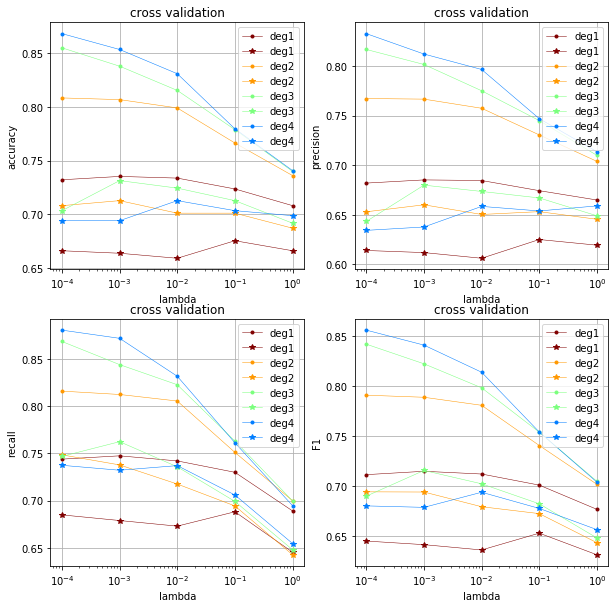

In [35]:
k_indices = build_k_indices(y_jet2, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet2, tX_jet2, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet2 = lambdas[idx[0]]
degree_ri_jet2 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet2, degree=degree_ri_jet2, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

In [36]:
w2_ri, loss2_ri, acc_measures2_ri, data_meas2_ri = build_final_model(y_jet2, tX_jet2, degree_ri_jet2,
                                                      lambda_ri_jet2, ml_function = 'ri', interaction = w_interaction)

print(acc_measures2_ri)

{'acc': 0.8232558139534883, 'pre': 0.7889447236180904, 'rec': 0.8219895287958116, 'f1': 0.8051282051282052}


## Logistic regression

### Full dataset

In [37]:
ltX = build_poly_inter(tX.copy(), 1, interaction = w_interaction)
ltX, _, _ = standardize_train(ltX)

In [38]:
yl = np.where(y==-1, 0, y)
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
initial_w = np.zeros(ltX.shape[1])

In [39]:
losses_lr = np.empty(len(gammas))
ws_lr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = logistic_regression(yl, ltX, initial_w, max_iters, gamma)
    losses_lr[idx] = loss
    ws_lr[idx, :] = w

/Users/Robin/Documents/EPFL/2019-2020/ML/Machine-learning-Project-2019/scripts/implementations.py:362: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))
/Users/Robin/Documents/EPFL/2019-2020/ML/Machine-learning-Project-2019/scripts/implementations.py:346: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))


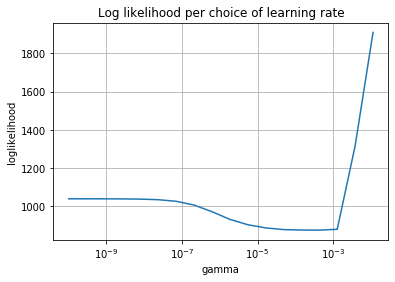

In [40]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [41]:
idx = np.nanargmin(losses_lr)

w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_lr, loss=losses_lr[idx], gamma = gamma_lr))

w* =[ 0.          0.01273124 -0.63793286 -0.75171381  0.22107602  0.72785648
  0.0455612  -0.20941217 -0.27518841  0.14637329  0.74006069  0.01534117
 -0.04018257  0.680729    0.04032226  0.00456669  0.08050579 -0.08896108
 -0.19905794  0.41831279  0.36884286 -0.07528857 -0.07561809 -0.54612908]

loglikelihood loss=875.9727959080919

gamma=0.0004281332398719387


#### Cross-validation for hyperparameter determination

In [42]:
seed = 1
k_fold = 4
degrees = range(1, 9)

k_indices = build_k_indices(y, k_fold, seed)

loss_tr_lr, loss_te_lr, acc_measures_lr = cross_validation_wAcc(yl, tX, k_indices, k_fold, degrees, lambdas = [0],
                                                                 ml_function = 'lr', max_iters = 1000, gamma = gamma_lr,
                                                                 verbose = True, interaction = w_interaction)

Finished preparing data for cross-validation 

Completed degree 8/8
 Completed lambda 1/1


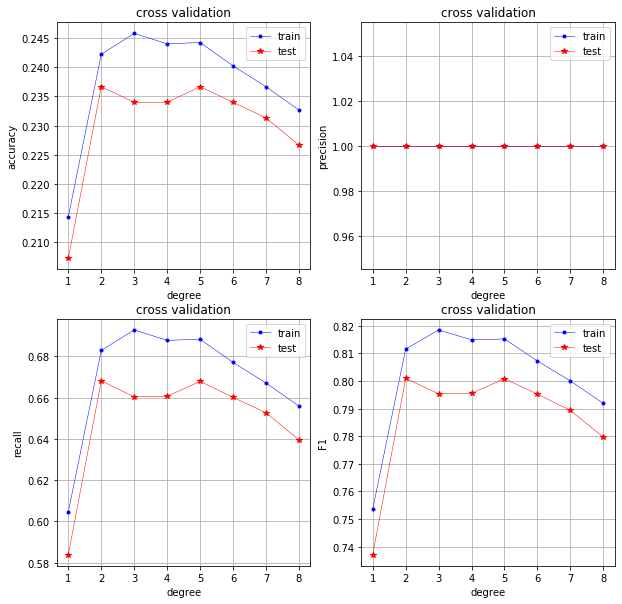

In [43]:
vis_cv_acc(degrees,lambdas,acc_measures_lr)

In [44]:
loss_te_lr = np.array(loss_te_lr)
loss_tr_lr = np.array(loss_tr_lr)

idx = np.nanargmax(acc_measures_lr["acc_te"])

degree_lr = degrees[idx]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    degree=degree_lr, loss_tr=loss_tr_lr.flatten()[idx], loss_te=loss_te_lr.flatten()[idx],
    acc_tr=acc_measures_lr["acc_tr"].flatten()[idx], acc_te=acc_measures_lr["acc_te"].flatten()[idx]))

degree*=2

loglikelihood train=596.2113126841083

loglikelihood test=216.214206408282

acc train=0.24222222222222223

acc test=0.2366666666666667


## Regularized logistic regression

### Full dataset

#### Cross-validation hyperparameter selection

In [45]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-8, -2, 5)
degrees = range(1, 5)

k_indices = build_k_indices(yl, k_fold, seed)

In [46]:
loss_tr_rlr, loss_te_rlr, acc_measures_rlr = cross_validation_wAcc(yl, tX, k_indices, k_fold, degrees,
                                                                   lambdas, ml_function = 'rlr', max_iters = 500,
                                                                   gamma = gamma_lr, verbose = True,
                                                                   interaction = w_interaction)

Finished preparing data for cross-validation 

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5


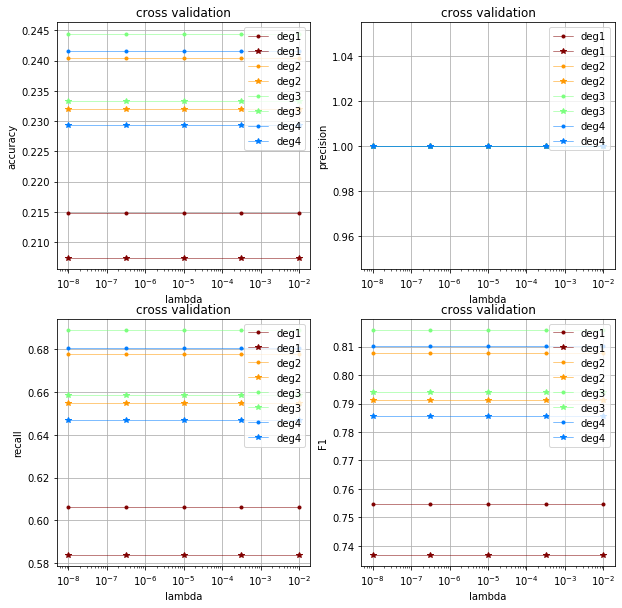

In [47]:
vis_cv_acc(degrees,lambdas, acc_measures_rlr)

In [48]:
idx = np.unravel_index(np.nanargmax(acc_measures_rlr["acc_te"]), acc_measures_rlr["acc_te"].shape)
lambda_rlr = lambdas[idx[0]]
degree_rlr = degrees[idx[1]]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    degree=degree_rlr, loss_tr=loss_tr_rlr[idx], loss_te=loss_te_rlr[idx],
    acc_tr=acc_measures_rlr["acc_tr"][idx], acc_te=acc_measures_rlr["acc_te"][idx]))

degree*=3

loglikelihood train=593.6429849453134

loglikelihood test=220.68408566323814

acc train=0.24444444444444444

acc test=0.23333333333333334


# Generate predictions and save ouput in csv format for submission:

In [49]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [50]:
indices = np.random.choice(tX_test.shape[0], 1500, replace=False)

In [51]:
tX_test = tX_test[indices,:]

##### Full dataset

In [52]:
y_pred = make_prediction(tx=tX_test.copy(), weights = w_ri.copy(), rmx = rmX.copy(), median = mtX.copy(),
                          d=degree_ri, train_data_measures=data_meas_ri, 
                         interactions = w_interaction, ml_function = "ri")

Deleting features...done
Imputing missing data...done
Building data matrix...done
(1500, 208) (208,)
Standardizing data matrix...done
Making predictions...done


In [53]:
OUTPUT_PATH = '../data/submission.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

##### Jet sub-datasets

In [54]:
y_test = np.zeros(tX_test.shape[0])
idx_test0, y_test0, tX_test0, idx_test1, y_test1, tX_test1, idx_test2, y_test2, tX_test2 = separate_jet(y_test, tX_test)

In [55]:
y_test0 = make_prediction(tX_test0, w0_ri, rmX_jet0, median_jet0,
                          degree_ri_jet0, data_meas0_ri, interactions = w_interaction, ml_function = "ri")

Deleting features...done
Imputing missing data...done
Building data matrix...done
(623, 55) (55,)
Standardizing data matrix...done
Making predictions...done


In [56]:
y_test1 = make_prediction(tX_test1, w1_ri, rmX_jet1, median_jet1,
                          degree_ri_jet1, data_meas1_ri, interactions = w_interaction, ml_function = "ri")

Deleting features...done
Imputing missing data...done
Building data matrix...done
(449, 45) (45,)
Standardizing data matrix...done
Making predictions...done


In [57]:
y_test2 = make_prediction(tX_test2, w2_ri, rmX_jet2, median_jet2,
                          degree_ri_jet2, data_meas2_ri, interactions = w_interaction, ml_function = "ri")

Deleting features...done
Imputing missing data...done
Building data matrix...done
(428, 88) (88,)
Standardizing data matrix...done
Making predictions...done


In [58]:
OUTPUT_PATH = '../data/submission_best3.csv'
y_pred = merge_jet(idx_test0, y_test0, idx_test1, y_test1, idx_test2, y_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)